#**XI.9.5.**
Для численного отыскания периодического с периодом единица решения уравнения 

$$
  y'' - P^2(x)y = f(x)
$$

где $P^2(x) > 0$ и $f(x)$ - Заданные периодические функции, используется разностная схема

$$
  \begin{cases}
    \frac{y_1 - 2 y_0 + y_{N-1}}{h^2} - P^2(0) y_0 = f(0), \\
    \frac{y_{n+1} - 2 y_n + y_{n-1}}{h^2} - P^2(nh) y_n = f(nh), \hspace{1cm} n = 1, 2, \dots, N-2, \\
    \frac{y_0 - 2 y_{N-1} + y_{N-2}}{h^2} - P^2(1-h) y_{N-1} = f(1 - h)
  \end{cases}
$$

где $Nh = 1$.

Вычислить решение при $h = 0.005$ в случае $P^2(x) = 10 + sin 2 \pi x$, $f(x) = cos 2 \pi x$

In [64]:
import numpy as np
import matplotlib.pyplot as plt

DEBUG = False

Соберем несколько функций, которые отразят нашу задачу в коде.

In [65]:
def PSqr(x):
  return 10 + np.sin(2 * np.pi * x)

def f(x):
  return np.cos(2 * np.pi * x)

def eqMatrix(P_func, f_func, h = 0.005, P_squared = False):
  N = int(1/h)
  A = np.eye(N)
  F = np.ones(N)

  for i in range(0, N):
    F[i] = f_func(i * h)
    A[i,i] = -(2 / (h**2) + (P_func(i * h))**(1 if P_squared else 2))
    A[i,i-1] = 1 / (h**2)
    A[i,(i+1)%N] = 1 / (h**2)

  if DEBUG: print(f'Matrix A:\n{A}\n\nMatrix F:\n{F}')

  return A, F

Теперь напишем набор функций, помогающий решать задачу на базе заданных условий в ячейке выше.

Венцом станет функция `solve`, которая в ответ на условия выдаст ответ.

In [66]:
def getCoeffs(A, F):
  coef_size = len(F)
  alpha = np.zeros(coef_size)
  beta = np.zeros(coef_size)
  gamma = np.zeros(coef_size)

  alpha[1] = -A[0,1] / A[0,0]
  beta[1] = F[0] / A[0,0]
  gamma[1] = -A[-1,0] / A[0,0]

  for i in range(1, coef_size-1):
    a, b, c, phi = A[i,i+1], A[i,i], A[i,i-1], F[i]
    alpha[i+1] = c / (-b - alpha[i] * a)
    beta[i+1] = (a * beta[i] - phi) / (-b - alpha[i] * a)
    gamma[i+1] = a * gamma[i] / (-b - alpha[i] * a)

  if DEBUG: print(f'alpha = {alpha}\nbeta = {beta}\ngamma = {gamma}')

  return alpha, beta, gamma

def getMuV(alpha, beta, gamma, A, F):
  muv_size = len(F)
  mu = np.zeros(muv_size)
  v = np.zeros(muv_size)
  mu[-1] = -A[-1,0] / (A[-1,-2] * (alpha[-1] + gamma[-1]) + A[-1,-1])
  v[-1] = (F[-1] - A[-1,-2] * beta[-1]) / (A[-1,-2] * (alpha[-1] + gamma[-1]) + A[-1,-1])

  for i in range(muv_size - 1, 0, -1):
    mu[i-1] = alpha[i] * mu[i] + gamma[i] * mu[muv_size - 1]
    v[i-1] = beta[i] + alpha[i] * v[i] + gamma[i] * v[muv_size - 1]

  return mu, v

def getSolution(alpha, beta, gamma, mu, v):
  y_size = len(alpha)

  y = np.ones(y_size)

  y[0] = v[0] / (1 - mu[0])
  y[-1] = mu[-1] * y[0] + v[-1]

  for i in range(y_size - 1, 0, -1):
    y[i-1] = alpha[i] * y[i] + beta[i] + gamma[i] * y[-1]

  if DEBUG: print(f'y = {y}')

  return y

def solve(P_func, f_func, eqMatrix_func, h = 0.005, P_squared = False):
  A, F = eqMatrix_func(P_func, f_func, h = h, P_squared = P_squared)
  alpha, beta, gamma = getCoeffs(A, F)
  mu, v = getMuV(alpha, beta, gamma, A, F)
  y = getSolution(alpha, beta, gamma, mu, v)
  x = np.linspace(0, 1, len(y))
  return x, y

Запустим эти функции и построим вожделенный график



Text(0, 0.5, '$y$')

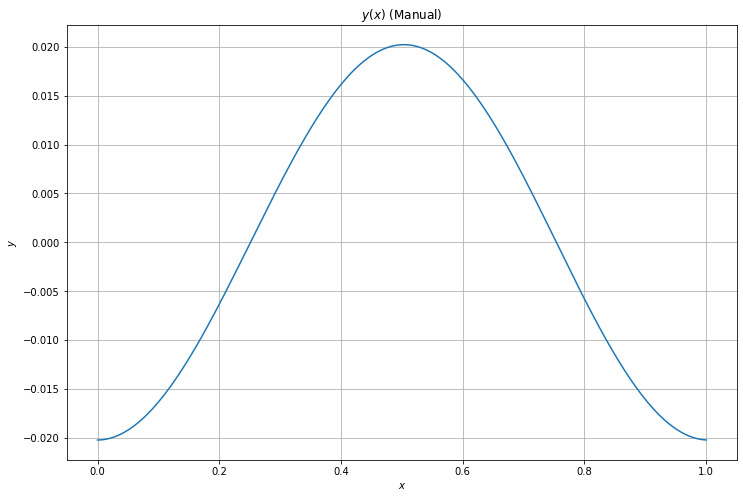

In [67]:
x, y = solve(PSqr, f, eqMatrix, P_squared=True)

plt.figure(figsize = [12, 8])
plt.plot(x, y)
plt.grid()
plt.title('$y(x)$ (Manual)')
plt.xlabel('$x$')
plt.ylabel('$y$')

Теперь решим задачу с помощью `linalg.solve`

Text(0, 0.5, '$y$')

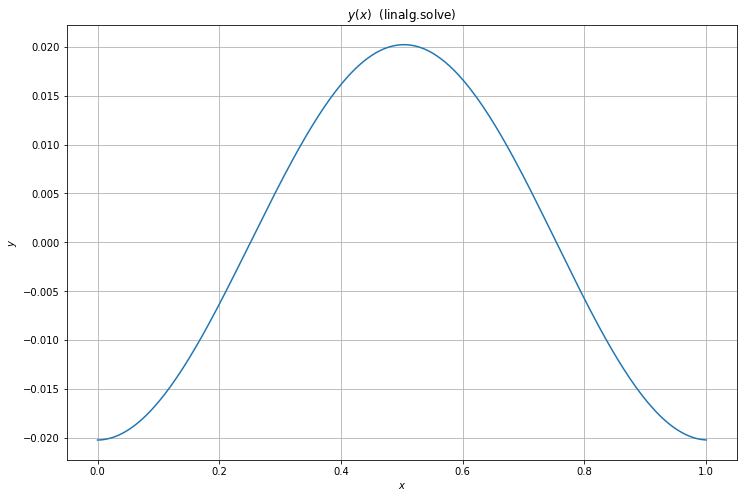

In [68]:
A, F = eqMatrix(PSqr, f, P_squared = True)
y = np.linalg.solve(A, F)
x = np.linspace(0, 1, len(y))

plt.figure(figsize = [12, 8])
plt.plot(x, y)
plt.grid()
plt.title('$y(x)$  (linalg.solve)')
plt.xlabel('$x$')
plt.ylabel('$y$')